In [11]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [12]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [13]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

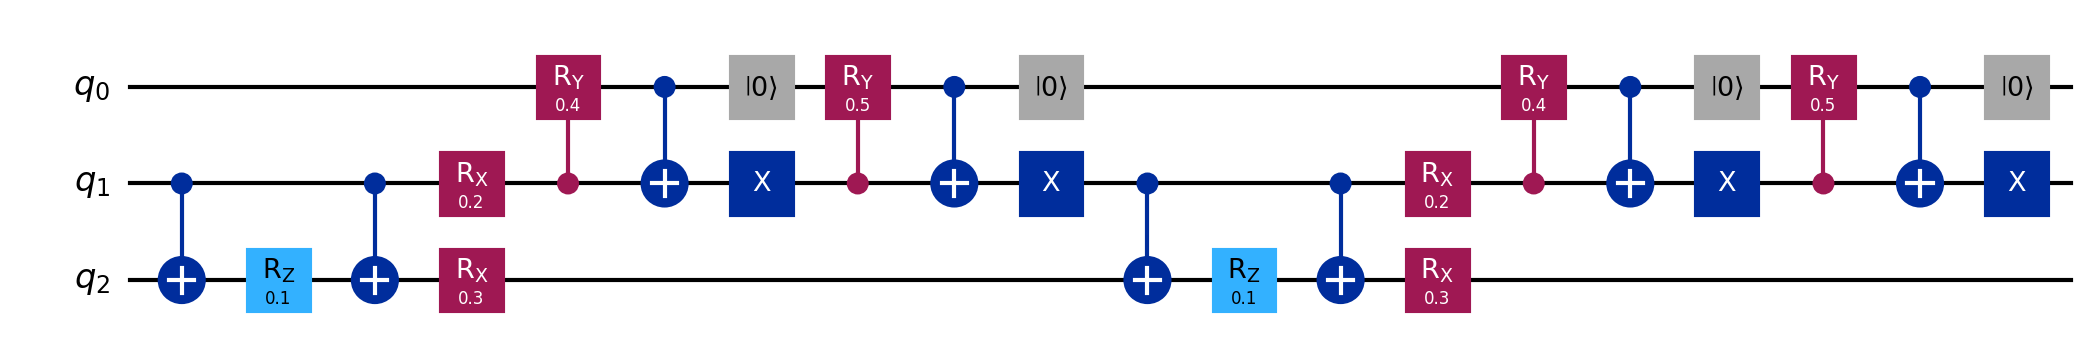

In [14]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

I = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

"""
The TFIM for L = 2 is given by: H = J * (Z_1 * Z_2) + h * (X_1 + X_2). We will consider
the two jump operators: L_1 = sqrt(g_1) * (X_1 - i * Y_1} and L_2 = sqrt(g_2) * (X_2 - i Y_2).

"""

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 2
def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 4

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               # Hamiltonian part.
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][0], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rx(angles_lst[i][1], 1)
               anstaz_circuit.rx(angles_lst[i][2], 2)
               # Jump operator part.
               anstaz_circuit.cry(angles_lst[i][3], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.reset(0)
               anstaz_circuit.x(1)
               anstaz_circuit.cry(angles_lst[i][4], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.x(1)
               anstaz_circuit.reset(0)
     return anstaz_circuit      

anstaz_circuit([[0.1, 0.2, 0.3, 0.4, 0.5],[0.1, 0.2, 0.3, 0.4, 0.5] ], 2).draw("mpl", scale = 1.5)     

In [15]:
J = 1.0
h = 1.0
gamma_1 = 1
gamma_2 = 0.5

def lindblad_equation(rho):
     """
     The Lindblad equation for the density matrix rho is given by: d rho / dt = -i [H, rho] + sum_i (L_i rho L_i^dagger - 0.5 {L_i^dagger L_i, rho}).
     """
     # Define the Hamiltonian.
     H = 1j * J * (np.kron(sigma_z, sigma_z) + h * (np.kron(sigma_x, I) + np.kron(I, sigma_x)))
     # Define the jump operators.
     L_1 = np.sqrt(gamma_1) * (np.kron(sigma_x, I) - 1j * np.kron(sigma_y, I))
     L_2 = np.sqrt(gamma_2) * (np.kron(I, sigma_x) - 1j * np.kron(I, sigma_y))
     # Define the Lindblad equation.
     d_rho_dt = -1j * (np.dot(H, rho) - np.dot(rho, H)) + np.dot(L_1, np.dot(rho, np.conj(L_1).T)) + np.dot(L_2, np.dot(rho, np.conj(L_2).T)) - 0.5 * (np.dot(np.conj(L_1).T, np.dot(L_1, rho)) + np.dot(np.conj(L_2).T, np.dot(L_2, rho)))
     return d_rho_dt     

In [16]:
def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [17]:
def cost_function(rho):
     L_rho = lindblad_equation(rho)
     return np.real(np.trace(L_rho.conj().T@L_rho))

# Variational algorithm for cost function optimization

In [ ]:
tolerance_for_convergence = 1.e-2
# Random initial angle parameters.
# Layer 1.
theta_11 = np.random.uniform(0, 2*np.pi)
theta_12 = np.random.uniform(0, 2*np.pi)
theta_13 = np.random.uniform(0, 2*np.pi)
theta_14 = np.random.uniform(0, 2*np.pi)
theta_15 = np.random.uniform(0, 2*np.pi)
# Layer 2.
theta_21 = np.random.uniform(0, 2*np.pi)
theta_22 = np.random.uniform(0, 2*np.pi)
theta_23 = np.random.uniform(0, 2*np.pi)
theta_24 = np.random.uniform(0, 2*np.pi)
theta_25 = np.random.uniform(0, 2*np.pi)

theta_11_values = [theta_11]
theta_12_values = [theta_12]
theta_13_values = [theta_13]
theta_14_values = [theta_14]
theta_15_values = [theta_15]

theta_21_values = [theta_21]
theta_22_values = [theta_22]
theta_23_values = [theta_23]
theta_24_values = [theta_24]
theta_25_values = [theta_25]

initial_learning_rate = 10

number_of_layers = 2 # Number of layers in the VQA circuit.

number_of_iterations = 0
max_iterations = 100

best_cost = float("inf")
best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15 = theta_11, theta_12, theta_13, theta_14, theta_15
best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25 = theta_21, theta_22, theta_23, theta_24, theta_25
best_iteration = 0

cost_function_values_lst = []

while number_of_iterations <= max_iterations:

    vqa_circuit = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                    [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    rho = return_density_matrix(vqa_circuit)
    cost_value = cost_function(rho)
    cost_function_values_lst.append(cost_value)

    if cost_value < best_cost:
        best_cost = cost_value
        best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15 = theta_11, theta_12, theta_13, theta_14, theta_15
        best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25 = theta_21, theta_22, theta_23, theta_24, theta_25
        best_iteration = number_of_iterations
    
    if cost_value <= tolerance_for_convergence:
        print("\n[CONVERGED] Cost function is less than the tolerance value.\n")
        print("Cost function =", cost_value)
        print("Parameters =", theta_11, theta_12, theta_13, theta_14, theta_15, theta_21, theta_22, theta_23, theta_24, theta_25)
        break

    # Decaying learning rate.
    learning_rate = initial_learning_rate / (1 + number_of_iterations)

    gradients = []

    # First layer.
    vqa_circuit_plus_theta_11 = anstaz_circuit([[theta_11 + np.pi/2, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_11 = anstaz_circuit([[theta_11 - np.pi/2, theta_12, theta_13, theta_14, theta_15],
                                                 [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_plus_theta_12 = anstaz_circuit([[theta_11, theta_12 + np.pi/2, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_12 = anstaz_circuit([[theta_11, theta_12 - np.pi/2, theta_13, theta_14, theta_15],
                                                    [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)      
    vqa_circuit_plus_theta_13 = anstaz_circuit([[theta_11, theta_12, theta_13 + np.pi/2, theta_14, theta_15], 
                                                [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_13 = anstaz_circuit([[theta_11, theta_12, theta_13 - np.pi/2, theta_14, theta_15],
                                                    [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)      

    vqa_circuit_plus_theta_14 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14 + np.pi/2, theta_15],
                                                [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_14 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14 - np.pi/2, theta_15],
                                                    [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)

    vqa_circuit_plus_theta_15 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15 + np.pi/2],
                                                [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_15 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15 - np.pi/2],
                                                    [theta_21, theta_22, theta_23, theta_24, theta_25]], number_of_layers)  
    # Second layer.                                                    
    vqa_circuit_plus_theta_21 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21 + np.pi/2, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_21 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],    
                                                    [theta_21 - np.pi/2, theta_22, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_plus_theta_22 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22 + np.pi/2, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_22 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                    [theta_21, theta_22 - np.pi/2, theta_23, theta_24, theta_25]], number_of_layers)
    vqa_circuit_plus_theta_23 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22, theta_23 + np.pi/2, theta_24, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_23 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                    [theta_21, theta_22, theta_23 - np.pi/2, theta_24, theta_25]], number_of_layers)
    vqa_circuit_plus_theta_24 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22, theta_23, theta_24 + np.pi/2, theta_25]], number_of_layers)
    vqa_circuit_minus_theta_24 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                    [theta_21, theta_22, theta_23, theta_24 - np.pi/2, theta_25]], number_of_layers)
    vqa_circuit_plus_theta_25 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                [theta_21, theta_22, theta_23, theta_24, theta_25 + np.pi/2]], number_of_layers)
    vqa_circuit_minus_theta_25 = anstaz_circuit([[theta_11, theta_12, theta_13, theta_14, theta_15],
                                                    [theta_21, theta_22, theta_23, theta_24, theta_25 - np.pi/2]], number_of_layers)

    gradient_theta_11 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_11)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_11))) / 2
    gradient_theta_12 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_12)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_12))) / 2
    gradient_theta_13 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_13)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_13))) / 2
    gradient_theta_14 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_14)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_14))) / 2
    gradient_theta_15 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_15)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_15))) / 2

    gradient_theta_21 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_21)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_21))) / 2
    gradient_theta_22 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_22)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_22))) / 2
    gradient_theta_23 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_23)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_23))) / 2
    gradient_theta_24 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_24)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_24))) / 2
    gradient_theta_25 = (cost_function(return_density_matrix(vqa_circuit_plus_theta_25)) - cost_function(return_density_matrix(vqa_circuit_minus_theta_25))) / 2

    # Parameter update.
    theta_11 = theta_11 - learning_rate * gradient_theta_11
    theta_12 = theta_12 - learning_rate * gradient_theta_12
    theta_13 = theta_13 - learning_rate * gradient_theta_13
    theta_14 = theta_14 - learning_rate * gradient_theta_14
    theta_15 = theta_15 - learning_rate * gradient_theta_15

    theta_21 = theta_21 - learning_rate * gradient_theta_21
    theta_22 = theta_22 - learning_rate * gradient_theta_22
    theta_23 = theta_23 - learning_rate * gradient_theta_23
    theta_24 = theta_24 - learning_rate * gradient_theta_24
    theta_25 = theta_25 - learning_rate * gradient_theta_25

    theta_11_values.append(theta_11)
    theta_12_values.append(theta_12)
    theta_13_values.append(theta_13)
    theta_14_values.append(theta_14)
    theta_15_values.append(theta_15)

    theta_21_values.append(theta_21)
    theta_22_values.append(theta_22)
    theta_23_values.append(theta_23)
    theta_24_values.append(theta_24)
    theta_25_values.append(theta_25)

    number_of_iterations += 1
    print("Cost function =", cost_value)
    print("Number of iterations =", number_of_iterations)
    print("Learning rate =", learning_rate)

    if number_of_iterations == max_iterations:
        print("\n[NOT CONVERGED] Maximum number of iterations reached.\n")
        print("Best cost function =", best_cost)
        print("Best parameters =", best_theta_11, best_theta_12, best_theta_13, best_theta_14, best_theta_15, best_theta_21, best_theta_22, best_theta_23, best_theta_24, best_theta_25)    
        print("Best iteration =", best_iteration)
        break

Cost function = 9.268945008155864
Number of iterations = 1
Learning rate = 10.0
Cost function = 5.338938992283709
Number of iterations = 2
Learning rate = 5.0
Cost function = 10.995025106798654
Number of iterations = 3
Learning rate = 3.3333333333333335
Cost function = 12.637186315539052
Number of iterations = 4
Learning rate = 2.5
Cost function = 12.414382864139297
Number of iterations = 5
Learning rate = 2.0
Cost function = 22.04287522718009
Number of iterations = 6
Learning rate = 1.6666666666666667
Cost function = 16.68507788494356
Number of iterations = 7
Learning rate = 1.4285714285714286
Cost function = 8.10459625532102
Number of iterations = 8
Learning rate = 1.25
Cost function = 5.408229314361123
Number of iterations = 9
Learning rate = 1.1111111111111112
Cost function = 16.1075448688228
Number of iterations = 10
Learning rate = 1.0
Cost function = 8.713691702845068
Number of iterations = 11
Learning rate = 0.9090909090909091
Cost function = 5.95859711142063
Number of iteratio

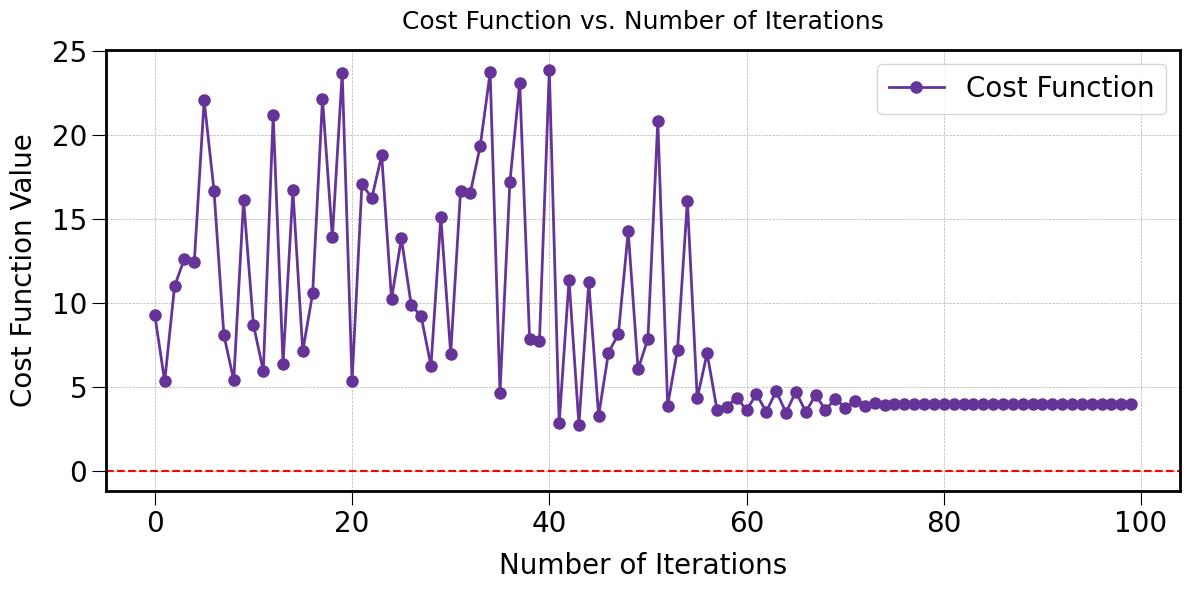

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")

plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")

# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)

plt.tight_layout()
plt.show()